In [64]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    

import sys, os
sys.path.append('../smc')
sys.path.append('../third_party')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm
import sys

from utils import *     # contains some useful helper functions 
from utils_data import *
from models import *    # toy models
from solvers import *   # matrix completion solvers
from methods import *
from wsc import *
from missingness_estimation import *

In [66]:
n_cols=800
n_rows=1000

In [67]:
loader = Load_MovieLens("../data/ml-100k")
M, mask_avail, mask_miss = loader.load_data(replace_nan=-1, num_columns=n_cols, num_rows=n_rows, random_state=2024)
demo = loader.load_demographics()
genre = loader.load_movie_info()

In [95]:
genre

,movieid,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,1671,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1673,1674,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1674,1675,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1678,1679,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [102]:
genre_counts = genre.iloc[:, 1:].sum().sort_values(ascending=False)
# Print the results
print("Number of movies in each genre:")
for genre_name, count in genre_counts.items():
    print(f"{genre_name}: {count}")

# Optional: Print total number of movies
total_movies = len(genre)
print(f"\nTotal number of movies: {total_movies}")

Number of movies in each genre:
Drama: 424
Comedy: 295
Thriller: 156
Romance: 146
Action: 145
Adventure: 80
Children's: 79
Crime: 65
Horror: 58
Sci-Fi: 57
War: 43
Musical: 39
Documentary: 35
Mystery: 35
Animation: 26
Film-Noir: 19
Western: 15
Fantasy: 9
unknown: 2

Total number of movies: 1000


In [168]:
bias=Movielens_weights(demo,genre)
w = bias.genre_weights(genre="Mystery")

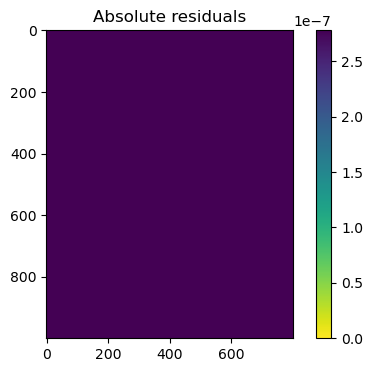

In [169]:
error_heatmap(w, np.zeros_like(w), np.ones_like(w))

In [170]:
# Matrix shape and rank
n1, n2 = M.shape
k = 5
r = 5
prop_train = 0.8
allow_inf = False
alpha = 0.1
random_state=0

In [171]:
max_test_queries = 50
sampler = QuerySampling(n1,n2)

# Randomly split the observed set into test set and training set
mask_obs, mask_test = sampler.sample_submask(mask=mask_avail, sub_size=prop_train, random_state=random_state)

# Sample test queries
n_test_queries = min(np.sum(np.sum(mask_test, axis=1) // k), max_test_queries)
idxs_test= sampler.sample_test(mask_test, k, test_size=n_test_queries, w=w, replace=True, random_state=random_state)

In [172]:
max_calib_queries = 2000
n_calib_queries = min(int(0.5 * np.sum(np.sum(mask_obs, axis=1) // k)), max_calib_queries)
mask_train, idxs_calib, mask_calib = sampler.sample_train_calib(mask_obs, k, 
                                        calib_size=n_calib_queries, random_state=random_state)

print("Observation size: {}, training size: {},  calib queries: {}, test queries: {}"
      .format(np.sum(mask_obs), np.sum(mask_train), int(np.sum(mask_calib)//k), len(idxs_test[0])//k))

Observation size: 41159, training size: 31159,  calib queries: 2000, test queries: 50


In [173]:
 Mhat, _, _=pmf_solve(M, mask_train, k=r, max_iteration = 10, random_state=random_state)

Iteration: 1; Mean diff: 0.0126
Iteration: 2; Mean diff: 0.0125
Iteration: 3; Mean diff: 0.0039
Iteration: 4; Mean diff: 0.0019
Iteration: 5; Mean diff: 0.0013
Iteration: 6; Mean diff: 0.0009
Iteration: 7; Mean diff: 0.0008
Iteration: 8; Mean diff: 0.0006
Iteration: 9; Mean diff: 0.0006
Iteration: 10; Mean diff: 0.0006


In [174]:
w_obs=estimate_P(mask_avail, 1, r=5)

iter: 1
iter: 2
iter: 3
iter: 4
iter: 5
iter: 6
iter: 7
iter: 8
iter: 9
iter: 10
iter: 11
iter: 12
iter: 13
iter: 14
iter: 15
iter: 16
iter: 17
Function value changing by less than progTol


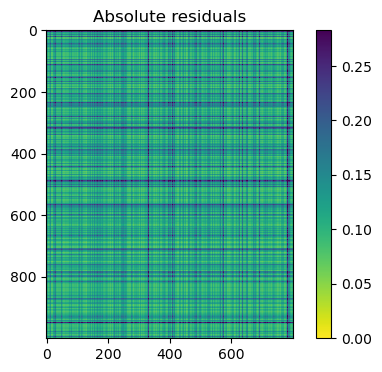

In [175]:
error_heatmap(w_obs, np.zeros_like(w_obs),np.ones_like(w_obs))

In [176]:
ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w_obs,parent_mask=None)
df = ci_method.get_CI(idxs_test, alpha, allow_inf=allow_inf)
lower, upper, is_inf= df.loc[0].lower, df.loc[0].upper, df.loc[0].is_inf

Computing conformal prediction intervals for 50 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.36it/s]

Done!


In [177]:
lower[lower <= 1] = 1
upper[upper >= 5] = 5

In [178]:
res = evaluate_SCI(lower, upper, k, M, idxs_test, is_inf=is_inf, method="SCMC")
res

,Query_coverage,Coverage,Size,metric,Inf_prop,Method
0,0.9,0.976,3.678834,mean,0.0,SCMC


In [179]:
ci_method = SimulCI(M, Mhat, mask_obs, idxs_calib, k, w_obs=w_obs,parent_mask=None)
df_cond = ci_method.get_CI(idxs_test, alpha, w_test=w, allow_inf=allow_inf)
lower_cond, upper_cond, is_inf_cond= df_cond.loc[0].lower, df_cond.loc[0].upper, df_cond.loc[0].is_inf

Computing conformal prediction intervals for 50 test queries...


CI: 100%|██████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 10.91it/s]

Done!


In [180]:
lower_cond[lower_cond <= 1] = 1
upper_cond[upper_cond >= 5] = 5

In [181]:
res = evaluate_SCI(lower_cond, upper_cond, k, M, idxs_test, is_inf=is_inf_cond, method="SCMC-cond")
res

,Query_coverage,Coverage,Size,metric,Inf_prop,Method
0,0.88,0.972,3.540819,mean,0.0,SCMC-cond
